This notebook summarizes the counts for target gene and DRSC regions.

In [2]:
# %load ../start.py
# Load useful extensions
import os
import sys

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 1

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
sys.path.insert(0, '../../lcdb-wf/lib')
sys.path.insert(0, '../../lib/python')

# Set up references
import yaml
with open('../../config/config.yml') as fh:
    config = yaml.load(fh)

assembly = config['assembly']
tag = config['aligner']['tag']
REF = os.path.join(os.environ['REFERENCES_DIR'], assembly, tag)

%matplotlib inline

last updated: 2017-09-22 

CPython 3.5.2
IPython 6.1.0
Git hash: b31c213e0fbaedf9092be694730dd537cd996a08


In [8]:
# imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
# get sample metadata
stable = pd.read_csv('../../config/sampletable.tsv', sep='\t')
srrs = stable.samplename.unique().tolist()
lacz = stable[stable.target_symbol == 'LacZ'].samplename.unique().tolist()
drsc = stable[stable.target_symbol != 'LacZ'].samplename.unique().tolist()

len(srrs), len(lacz), len(drsc)

(1900, 20, 1880)

In [7]:
# imports drsc adjusted counts tables
dfs = []
pattern = '../../rnaseq-wf/data/rnaseq_samples/{srr}/{srr}.cutadapt.bam.drsc.counts'
for srr in drsc:
    fname = pattern.format(srr=srr)
    if os.path.exists(fname):
        dfs.append(pd.read_table(fname))

df = pd.concat(dfs, ignore_index=True)

print(df.shape)
df.head()

(1880, 9)


,srr,drsc,drsc_count,drsc_length,gene,gene_count,gene_length,sub_count,sub_length
0,SRR3486891,DRSC07681,336,513,FBgn0003396,911,10997,593,10484
1,SRR3486986,DRSC07681,221,513,FBgn0003396,391,10997,170,10484
2,SRR3487576,DRSC15627,163,141,FBgn0038742,181,1418,20,1277
3,SRR3487481,DRSC15627,35,141,FBgn0038742,57,1418,24,1277
4,SRR3486819,DRSC32770,21,158,FBgn0011715,125,1335,110,1177


In [49]:
# plotting function
def make_plot(x, y, xlabel, ylabel, ax):
    ax.scatter(x, y, color='k', s=3)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', c='g')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    axmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
    axmax = min(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(axmin, axmax)
    ax.set_ylim(axmin, axmax)

# Raw Counts

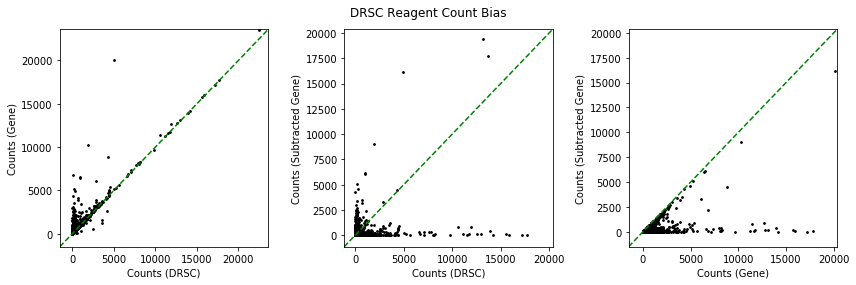

In [52]:
# Plot Raw counts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3))
make_plot(df['drsc_count'], df['gene_count'], 'Counts (DRSC)', 'Counts (Gene)', ax1)
make_plot(df['drsc_count'], df['sub_count'], 'Counts (DRSC)', 'Counts (Subtracted Gene)', ax2)
make_plot(df['gene_count'], df['sub_count'], 'Counts (Gene)', 'Counts (Subtracted Gene)', ax3)
plt.suptitle('DRSC Reagent Count Bias')
plt.tight_layout(rect=[0, 0, 1, .95])

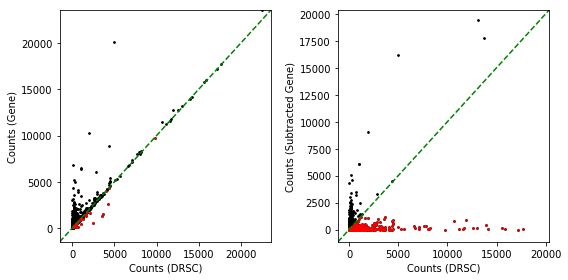

In [58]:
# Plot Raw counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
make_plot(df['drsc_count'], df['gene_count'], 'Counts (DRSC)', 'Counts (Gene)', ax1)
make_plot(df['drsc_count'], df['sub_count'], 'Counts (DRSC)', 'Counts (Subtracted Gene)', ax2)

mask1 = df['drsc_count'] > df['gene_count']
ax1.scatter(df.loc[mask1, 'drsc_count'], df.loc[mask1, 'gene_count'], s=2, c='r')

mask2 = df['drsc_count'] > df['sub_count']
ax2.scatter(df.loc[mask2, 'drsc_count'], df.loc[mask2, 'sub_count'], s=2, c='r')
plt.tight_layout()

In [90]:
grp = df[mask1].groupby('drsc')
highly_biased = grp['drsc'].count().to_frame().sort_values(by='drsc')
highly_biased.columns = ['num_highly_biased']

In [91]:
grp = df[mask2].groupby('drsc')
lower_biased = grp['drsc'].count().to_frame().sort_values(by='drsc')
lower_biased.columns = ['num_lower_biased']

In [120]:
all_drsc = df[['drsc', 'gene']].copy().drop_duplicates()
all_drsc.set_index('drsc', inplace=True)

In [125]:
mbias = all_drsc.join([highly_biased, lower_biased], how='left')
mbias.fillna(0, inplace=True)

In [128]:
pd.crosstab(mbias.num_highly_biased.astype(int), mbias.num_lower_biased.astype(int))

num_lower_biased,0,1,2
num_highly_biased,,,
0,251,120,533
1,0,3,15
2,0,0,18


In [94]:
mbias.fillna(0, inplace=True)

In [98]:
mbias = mbias.astype(int)

In [100]:
mbias.head()

,num_highly_biased,num_lower_biased
drsc,,
DRSC00309,0,2
DRSC00324,0,2
DRSC00451,0,2
DRSC00467,1,1
DRSC00471,0,2


In [141]:
ct = pd.crosstab(mbias.num_highly_biased, mbias.num_lower_biased)

In [160]:
ct

num_lower_biased,0.0,1.0,2.0
num_highly_biased,,,
0.0,251,120,533
1.0,0,3,15
2.0,0,0,18


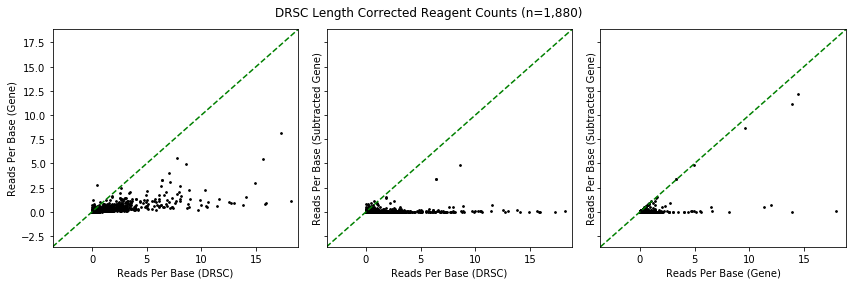

In [130]:
# Length normalized counts
drsc_rpb = df.drsc_count / df.drsc_length
sub_rpb = df.sub_count / df.sub_length
gene_rpb = df.gene_count / df.gene_length

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharex=True, sharey=True)
    
make_plot(drsc_rpb, gene_rpb, 'Reads Per Base (DRSC)', 'Reads Per Base (Gene)', ax1)
make_plot(drsc_rpb, sub_rpb, 'Reads Per Base (DRSC)', 'Reads Per Base (Subtracted Gene)', ax2)
make_plot(gene_rpb, sub_rpb, 'Reads Per Base (Gene)', 'Reads Per Base (Subtracted Gene)', ax3)
plt.suptitle('DRSC Length Corrected Reagent Counts (n={:,})'.format(len(drsc)))
plt.tight_layout(rect=[0, 0, 1, .95])